# Movie Recommender Model

### Introduction

#### Data Set

The data set used for this project is from MovieLens. It contains ~1 million movie ratings from ~4000 movies and ~6000 users. (Due to the large size of the data set, care must be taken to optimize similarity matrix calculation through the use of avialable optimized matrix operations from numpy and scipy).


#### Model Overview

This project optimizes a custom recommendation model (on which a recommender system can be based) that uses a weighted average of different user and item similarity models. The overall model for predicting whether a user will watch a movie is the weighted average of a collaborative filtering model and a content-based filtering model. 

The collaborative filtering model determines similarity of users by their demographic data (gender, age, occupation, zip code), the similarity in their movie genre profiles (which types of movies they watched), similarity in latent factors extracted from a matrix of users and movies with non-negative matrix factorization, and finally by similarity in ratings for movies watched by both users being compared. The ratings of the most similar users are averaged for prediction.

The content-based filtering model determines similarity of a movie to movies a user has watched before. The content is compared using genre and latent factors (from matrix factorization). Since a user may like many different types of movies (distribution of movies watched by user may not be unimodal), a nearest-neighbors approach is used instead of an tf-idf approach. So the similarity between a movie and the movies the user watched before is the mean of similarity between the movie and its k nearest neighbors in feature space. The value of k may need to be large enough to distinguish between differences in the densities of the clusters. The content-based filtering model will only be used to predict whether a user will watch a movie, not the rating. This is because users may pick a movie based on the content (genre), but movies of the same type may be rated differently based on the quality of the individual movie.

#### Similarity Measures

Cosine similarity $$\frac{\vec{u}\cdot\vec{v}}{|\vec{v}||\vec{u}|}$$ is used for most similarity calculations (where the direction of the vector matters more than the magnitude). This calculation has the advantage that the denominator need not be calculated if the vectors are already normalized, which means the entire similarity matrix can be calculated as $XX^T$, where $X$ is an n (data points) by m (features) matrix.

For comparison of user demographic data, since age and zip-code are continuous variables (e.g. we want to distibguish between between (age, zipcode) = (30,45000) and (60,90000)), the similarity is calculated from the squared Euclidean distance as
$$1-\frac{|\vec{u}-\vec{v}|^2}{5}$$
The factor of 5 ensures the result will always be between 0 and 1. Efficient calculation of the distances can be achieved using scipy.spatial.distance.cdist().

For ratings comparison, we also want to distinguish between vectors of different magnitude. For example we want to distinguish between someone who rated four movies as (1,1,1,1) and someone who rated them (5,5,5,5). However, there is an additional complication here. Between any 2 users, similarity in ratings can only be determined from the number of movies they both rated ($n_{common}$). Euclidean distance will grow approximately as the $\sqrt{n_{common}}$ for random normally distributed variables, therefore the distance must be corrected for this factor, resulting in the expression for the root mean squared distance. So the similarity is defined as
$$1-\frac{|\vec{u}-\vec{v}|^2}{16 n_{common}}$$
The factor of 16 ensures the result will always be between 0 and 1. 

The distance above should only be calculated from movies that were watched by both users. It would be inefficient to truncate the vectors and calculate the norm of the difference for every pair of uers. An alternative approach is derived as follows. Let $W$ be an $n\times m$ vector where $n$ is the number of users and $m$ is the number of movies. Each entry in $W$ is 1 if the user watched the movie (inferred from ratings data) and 0 otherwise. Let $R$ be the $n \times m$ vector of movie ratings, where the entry is the rating the user gave for the movie, or 0 if the user did not watch the movie.

The desired squared distance between user vectors (row vectors) is
$$|R_{i\cdot}'-R_{j\cdot}'|^2 =|R_{i\cdot}'|^2-2(R_{i\cdot}'\cdot\ R_{j\cdot}')+|R_{j\cdot}'|^2$$
Where the prime represents the truncation of the vectors to only include elements in positions where the other vector is not zero.

Note first that $R_{i\cdot}'\cdot\ R_{j\cdot}' = R_{i\cdot}\cdot\ R_{j\cdot}$ because the when calculating the dot product if either vector has a 0 the product is zero for that position, so that corresponding term in the sum will be 0. 

Also, $|R_{i\cdot}'|^2 =R_{i\cdot}' \cdot R_{i\cdot}'= (R_{i\cdot}\circ R_{i\cdot})\cdot W_{j\cdot}$ where $\circ$ is entrywise multiplication (Hadamard product). Therefore 
$$|R_{i\cdot}'-R_{j\cdot}'|^2 =(R_{i\cdot}\circ R_{i\cdot})\cdot W_{j\cdot}-2(R_{i\cdot}\cdot\ R_{j\cdot})+(R_{j\cdot}\circ R_{j\cdot})\cdot W_{i\cdot}$$
This can be expressed in terms of matrix multiplication as
$$D_{ij} =((R\circ R)W^T)_{ij}-2(RR^T)_{ij}+((R\circ R)W^T)_{ji}$$
Where $D$ is the squared distance matrix. Then
$$D =(R\circ R)W^T-2RR^T+((R\circ R)W^T)^T$$

Then note that the number of movies common to users i and j, $n_{ij}=W_i\cdot W_j$ and so the matrix representation is $N=WW^T$.

Thus the similarity matrix is calculated as $1-D/(16N)$ where / is entrywise division.

#### Importing libraries:

In [504]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.spatial import distance
from matplotlib import pyplot as plt

### Verification of Data

Importing Data

In [11]:
movies = pd.read_csv('C:/Datasets/movies.dat','::',header = None, names= ['MovieID','Title','Genre'])
users = pd.read_csv('C:/Datasets/users.dat','::',header = None, names= ['UserID','Gender','Age','Occupation','ZipCode'])
ratings = pd.read_csv('C:/Datasets/ratings.dat','::',header = None, names= ['UserID','MovieID','Rating','Timestamp'])

C:\Users\Nolan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\Nolan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\Nolan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from th

In [12]:
movies.head(5)

,MovieID,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
users.head(5)

,UserID,Gender,Age,Occupation,ZipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [14]:
ratings.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Verifying Quality of Data

In [4]:
# Check for duplicate records
print('Duplicated movie records:',sum(movies.duplicated()))
print('Duplicated user records:',sum(users.duplicated()))
print('Duplicated rating records',sum(ratings.duplicated()))

# Check for NAs
print('Missing values in movie records: ',sum(sum(np.where(movies.astype(str)=='',1,0))))
print('Missing values in user records: ',sum(sum(np.where(users.astype(str)=='',1,0))))
print('Missing values in rating records: ',sum(sum(np.where(ratings.astype(str)=='',1,0))))

# Check for ratings that don't correspond to user or movie
print('Ratings not corresponding to User or Movie data tables:',
     len(ratings)-len(ratings[(ratings.UserID.isin(users.UserID))&(ratings.MovieID.isin(movies.MovieID))]))

Duplicated movie records: 0
Duplicated user records: 0
Duplicated rating records 0
Missing values in movie records:  0
Missing values in user records:  0
Missing values in rating records:  0
Ratings not corresponding to User or Movie data tables: 0


### Pre-Processing

Features corresponding to each genre are extracted from the Genre column. These features are binary (0 if movie is not in the genre, 1 if the movie is in the genre).

In [15]:
# Split the Genre values into a list of genres
movies.Genre = movies.Genre.str.split('|')

# Pre-Processing
# Define a list of all genres
genrelist = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir',
             'Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

# Create columns of 0's for each genre
for x in genrelist:
    movies = movies.join(pd.DataFrame({x:0},index=movies.index))

# Change each genre column value to 1 if the genre is in the movie's genre list
def genredummy(row):
    for x in range(len(genrelist)):
        if genrelist[x] in row['Genre']:
            row[3+x]=1
    return row

movies = movies.apply(genredummy, axis=1).drop('Genre',axis=1)

In [16]:
movies.head(5)

,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Movie genre vectors are normalized (to make similarity calculation more efficient later on).

In [17]:
# Normalize Movies Genre Vectors
movies.iloc[:,2:] = movies.iloc[:,2:].div(movies.iloc[:,2:].apply(np.linalg.norm,axis=1),axis=0)

movies.head(5)

,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0.0,0.00000,0.57735,0.57735,0.577350,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0.0,0.57735,0.00000,0.57735,0.000000,0.0,0.0,0.000000,0.57735,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.00000,0.00000,0.00000,0.707107,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.00000,0.00000,0.00000,0.707107,0.0,0.0,0.707107,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.00000,0.00000,0.00000,1.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Since gender and occupation are not continuous or ordinal, these factors will be dummy coded. Since gender only has 2 levels, the feature for female is dropped. All features for occupation are kept to keep distance measurements balanced such that any two different occupations would result in the same distance.

Zip code will also be truncated to the first 5 digits in case some are entered with an additional four digit local area code. The age and zip code will be scaled by the maximum possible value, so that all values are between 0 and 1.

In [18]:
# Dummy Code the User Information
users = pd.get_dummies(users,columns=['Gender','Occupation']).drop('Gender_F',axis=1)

# For consistency, truncate zip codes to first 5 digits
users.ZipCode = users.ZipCode.str[:5]

# Scale age and zip code
users.Age = users.Age.astype(int)/56
users.ZipCode = users.ZipCode.astype(int)/100000

users.head(5)

,UserID,Age,ZipCode,Gender_M,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,1,0.017857,0.48067,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.000000,0.70072,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,0.446429,0.55117,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0.803571,0.02460,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0.446429,0.55455,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


For the purposes of cross-validation, the ratings data set will be arranged in order of timestamp instead of randomized. This ensures that any real life temporal effects are captured.

In [19]:
# Sort Ratings by Timestamp
ratings = ratings.sort_values('Timestamp',axis=0).reset_index(drop=True)

### Recommender System Functions

Below are all the functions used in generating similarity matrices, making predictions, and cross-validation.

#### Low Level Functions

User similarity based on user demographic information is the same for any pair of users regardless of the training set or data set, so the user similarity matrix need only be calculated once.

In [248]:
def usersimilarity(df):
    n = len(df)
    usermatrix = 1-distance.cdist(df.iloc[:,1:], df.iloc[:,1:], metric = 'sqeuclidean')/5
    return pd.DataFrame(usermatrix, index=range(1,n+1), columns=range(1,n+1))

In [249]:
usersimmatrix = usersimilarity(users)

The remaining similarity matrices all are specific to the training set. 

Therefore, a list of users and movies in the training set must be created.

In [30]:
def userlist(traindf):
    return traindf.UserID.unique()

def movielist(traindf):
    return traindf.MovieID.unique()

A movie profile matrix is created with rows representing movies and columns representing users. An entry in the matrix is 1 if the user watched (rated) the movie, and 0 otherwise. 

In [351]:
def movieprofile(traindf, userslist, movieslist):
    movieprofilematrix = np.zeros((len(movieslist),len(userslist)))
    moviedict = dict(zip(movieslist,range(len(movieslist))))
    userdict = dict(zip(userslist,range(len(userslist))))
    def entry(row):
        movieprofilematrix[moviedict[row[1]]][userdict[row[0]]]=1
    np.apply_along_axis(entry,1,traindf)
    movieprofiledf = pd.DataFrame(movieprofilematrix, index=movieslist, columns=userslist)
    return movieprofiledf

In [47]:
def normmovieprofile(movieprofiledf):
    return movieprofiledf.div(movieprofiledf.apply(np.linalg.norm,axis=0), axis =1)

In the genre matrix created below, rows represent movies and columns represent genres. It is a subset of the movies dataframe.

In [216]:
def genrematrix(movieslist):
    return pd.DataFrame({'MovieID':movieslist}, index=movieslist).merge(
        movies,on='MovieID',how='left').iloc[:,2:].rename(dict(zip(range(len(movieslist)),movieslist)),axis='index')

The user genre matrix is generated by matrix multiplication of the transpose of the movieprofile matrix and the genre matrix. It results in a matrix where rows represent users and columns represent genres. Each user is associated with a row vector that is the genre profile for the user.

In [59]:
def usergenre(normmovieprofiledf, genredf):
    rawmatrix = normmovieprofiledf.T.dot(genredf)
    normalizedmatrix = rawmatrix.div(rawmatrix.apply(np.linalg.norm,axis=1),axis=0)
    return normalizedmatrix

The following function performs matrix factorization on the movie profile matrix in order to extract n latent features.

In [65]:
def matrixfactorize(movieprofiledf, n):
    NMF = decomposition.NMF(n)
    NMF.fit(movieprofiledf.T)
    return NMF

The following is a general function for creating a similarity matrix using cosine similarity.

In [178]:
def similaritymatrix(df):
    simmatrix = df.dot(df.T)
    return pd.DataFrame(simmatrix, index=df.index, columns=df.index)

The rating matrix contains rows that represent users and columns that represent movies. The entries in the matrix is the rating. If the movie was not watched, the entry is 0.

In [352]:
def ratingmatrix(traindf, usermoviesdf):
    userratingmatrix = np.zeros((len(movieslist),len(userslist)))
    moviedict = dict(zip(movieslist,range(len(movieslist))))
    userdict = dict(zip(userslist,range(len(userslist))))
    def entry(row):
        userratingmatrix[moviedict[row[1]]][userdict[row[0]]]=row[2]
    np.apply_along_axis(entry,1,traindf)
    userratingdf = pd.DataFrame(userratingmatrix, index=movieslist, columns=userslist)
    return userratingdf.T

The following function generates a user similarity matrix based on user ratings, using the mean squared Euclidean distance, as described in the introduction.

In [188]:
def ratingsimilarity(usermoviesdf, ratingdf):
    watchwatchmatrix = usermoviesdf.dot(usermoviesdf.T)
    ratewatchmatrix = (ratingdf**2).dot(usermoviesdf.T)
    watchratematrix = ratewatchmatrix.T
    rateratematrix = ratingdf.dot(ratingdf.T)
    distmatrix = ratewatchmatrix + watchratematrix - 2*rateratematrix 
    simmatrix = watchwatchmatrix.where(watchwatchmatrix==0, 1-distmatrix/watchwatchmatrix/16)
    return pd.DataFrame(simmatrix, index=usermoviesdf.index, columns=usermoviesdf.index)

The item similarity function returns the mean cosine similarity between a movie and the k nearest neighbors from the movies that a user watched. The item similarity rate function resturns the associated mean rating for those k similar movies.

In [124]:
def itemsimilarity(featuredf, moviesprofiledf, UserID, MovieID, k):
    userhistory = moviesprofiledf.loc[:,UserID]
    userhistory = userhistory[userhistory ==1]
    userfeatures = userhistory.align(featuredf, axis=0, join= 'left')[1]
    cosines = userfeatures.apply(lambda row: np.dot(row,featuredf.loc[MovieID,:]),axis =1)
    similarity = cosines.nlargest(k).mean()
    return similarity

In [299]:
def itemsimilarityrate(featuredf, moviesprofiledf, ratingdf, UserID, MovieID, k):
    userhistory = moviesprofiledf.loc[:,UserID]
    userhistory = userhistory[userhistory ==1]
    userfeatures = userhistory.align(featuredf, axis=0, join= 'left')[1]
    cosines = userfeatures.apply(lambda row: np.dot(row,featuredf.loc[MovieID,:]),axis =1)
    similaritylist = list(cosines.nlargest(k).index.values)
    itemrate = ratingdf.loc[UserID,similaritylist].mean()
    return itemrate

#### High Level Functions

First a data frame is created to store the accuracy and RMSE results of each parameter combination. Also, a list of previous parameter values is created to minimize recalculation.

In [194]:
# Create Dataframe to hold optimization scores
parameters = ['n','k','N','Wg','Wl','Wr','Wi','Wil','Accuracy','RMSE']
optimizationresults = pd.DataFrame(columns=parameters)

# Create a list of previous parameter values
previousparameters = []

The  following function runs the recommendation model on a training set and predicts results for a test set, given the values of 8 hyperparameters.

n = number of latent factors for matrix factorization,
k = number of nearest neighbors for calculation of item similarity,
N = number of nearest neighbors to use for prediction of veiwing/ratings.
The remaining hyperparameters are the weights for the weighted averaging of various similarity measures.

Built into the model are different calculations if the movie or user is not in the training set. If the user is not in the training set, only the demographic information can be used to find similar users. If the movie is not in the training set, only the genre information can be used to find similar movies.

In [481]:
def recommendmodel(i, fold, n, k, N, Wgenre, Wlatent, Wrating, Witem, Witemlatent, sub=False):
    global optimizationresults
    global previousparameters
    global trainratings
    global testratings
    def calcsplit():
        globals()['userslist'] = userlist(trainratings)
        globals()['testuserslist'] = userlist(testratings)
        globals()['movieslist'] = movielist(trainratings)
        globals()['moviesprofiledf'] = movieprofile(trainratings, userslist, movieslist)
        globals()['normmoviesprofiledf'] = normmovieprofile(moviesprofiledf)
        globals()['usermoviesdf'] = moviesprofiledf.T
        globals()['genredf'] = genrematrix(movieslist)
        globals()['usergenredf'] = usergenre(normmoviesprofiledf,genredf)
        globals()['ratingdf'] = ratingmatrix(trainratings, usermoviesdf)
        globals()['usergenresimmatrix'] = similaritymatrix(usergenredf)
        globals()['ratingsimmatrix'] = ratingsimilarity(usermoviesdf, ratingdf)
        globals()['userdemosimmatrix'] = usersimmatrix.loc[userslist,userslist]
    def calcn():
        globals()['NMFmodel'] = matrixfactorize(moviesprofiledf, n)
        globals()['userlatentdf'] = pd.DataFrame(NMFmodel.transform(usermoviesdf),index=userslist)
        globals()['userlatentdf'] = userlatentdf.div(userlatentdf.apply(np.linalg.norm,axis=1), axis = 0)
        globals()['movieslatent'] = pd.DataFrame(NMFmodel.components_, columns=movieslist)
        globals()['latentdf'] = movieslatent.T.div(movieslatent.T.apply(np.linalg.norm,axis=1), axis = 0)
        globals()['userlatentsimmatrix'] = similaritymatrix(userlatentdf)
    def calcW():
        globals()['weightedsimmatrix'] = (1-Wgenre-Wlatent-Wrating)*userdemosimmatrix+Wgenre*usergenresimmatrix+\
                        Wlatent*userlatentsimmatrix+Wrating*ratingsimmatrix
    def calcNN():
        globals()['NNlist'] = dict(zip(testuserslist,[[]]*len(testuserslist)))
    if previousparameters == [] or previousparameters[0:2] != [i,fold]:
            splitdata(i, fold, sub)
            calcsplit()
            calcn()
            calcW()
            calcNN()
    else:  
        if previousparameters[2] != n:
            calcn()
        if [previousparameters[2]]+previousparameters[5:8] != [n, Wgenre, Wlatent, Wrating]:
            calcW()
        if previousparameters[0:3]+previousparameters[4:8] != [i, fold, n, N, Wgenre, Wlatent, Wrating]:
            calcNN()
    testratings['watchpredict'] = 0
    testratings['ratepredict'] = 0
    def predict(row):
        global NNlist
        if row.UserID not in userslist:
            simvector = usersimmatrix.loc[userslist,row.UserID]
            if NNlist[row.UserID]==[]:
                NNlist[row.UserID] = list(simvector.nlargest(N,keep='all').index.values)
            if row.MovieID not in movieslist:
                samegenre = list(genredf.loc[(genredf==np.array(movies.loc[movies.MovieID == row.MovieID,genrelist])).product(axis=1)==1,:].index.values)
                simratevector = simvector[usermoviesdf.loc[simvector.index, samegenre].sum(axis=1)>0]
                NNrate = list(simratevector.nlargest(N, keep='all').index.values)
                if NNrate != []:
                    row['ratepredict'] =round(trainratings.loc[(trainratings.MovieID.isin(samegenre))&(trainratings.UserID.isin(NNrate)),
                                                  'Rating'].mean())
                    row['watchpredict'] = round(len(set(NNlist[row.UserID]).intersection(NNrate))/len(NNlist[row.UserID]))
                else:
                    if samegenre != []:
                        row['ratepredict'] = round(trainratings.loc[(trainratings.MovieID.isin(samegenre)),'Rating'].mean())
                    else:
                        row['ratepredict'] = round(trainratings.loc[:,'Rating'].mean())
                    row['watchpredict'] = 0
            else:
                simratevector = simvector[usermoviesdf.loc[simvector.index, row.MovieID]==1]
                NNrate = list(simratevector.nlargest(N, keep='all').index.values)
                row['ratepredict'] = round(ratingdf.loc[NNrate,row.MovieID].mean())
                row['watchpredict'] = round(usermoviesdf.loc[NNlist[row.UserID],row.MovieID].mean())
        else:
            simvector = weightedsimmatrix.loc[:,row.UserID]
            if NNlist[row.UserID]==[]:
                NNlist[row.UserID] = list(simvector.nlargest(N,keep='all').index.values)
            if row.MovieID not in movieslist:
                samegenre = list(genredf.loc[(genredf==np.array(movies.loc[movies.MovieID == row.MovieID,genrelist])).product(axis=1)==1,:].index.values)
                simratevector = simvector[usermoviesdf.loc[simvector.index, samegenre].sum(axis=1)>0]
                NNrate = list(simratevector.nlargest(N, keep='all').index.values)
                if NNrate != []:
                    collabrate =trainratings.loc[(trainratings.MovieID.isin(samegenre))&(trainratings.UserID.isin(NNrate)),
                                                  'Rating'].mean()
                else:
                    if samegenre != []:
                        collabrate =trainratings.loc[(trainratings.MovieID.isin(samegenre)),'Rating'].mean()
                    else:
                        collabrate =trainratings.loc[:,'Rating'].mean()
                itemrate = itemsimilarityrate(genredf, moviesprofiledf, ratingdf, row.UserID,samegenre[0],k)
                collabwatch = len(set(NNlist[row.UserID]).intersection(NNrate))/len(NNlist[row.UserID])
                itemwatch = itemsimilarity(genredf, moviesprofiledf,row.UserID,samegenre[0],k)
                row['watchpredict'] = round((1-Witem)*collabwatch+Witem*itemwatch)
                if row['watchpredict'] == 0:
                    row['ratepredict'] = round(collabrate)
                else:
                    row['ratepredict'] = round((1-Witem)*collabrate+Witem*itemrate)
            else:
                collabwatch = usermoviesdf.loc[NNlist[row.UserID], row.MovieID].mean()
                itemwatch = (1-Witemlatent)*itemsimilarity(genredf, moviesprofiledf,row.UserID,row.MovieID,k) +\
                            Witemlatent*itemsimilarity(latentdf, moviesprofiledf,row.UserID,row.MovieID,k)
                row['watchpredict'] = round((1-Witem)*collabwatch+Witem*itemwatch)
                simratevector = simvector[usermoviesdf.loc[simvector.index, row.MovieID] == 1]
                NNrate = list(simratevector.nlargest(N, keep='all').index.values)
                row['ratepredict'] = round(ratingdf.loc[NNrate,row.MovieID].mean())
        return row
    testratings.apply(predict,axis=1)
    accuracy =testratings['watchpredict'].sum()/len(testratings)*100
    RMSE = (((testratings.Rating-testratings['ratepredict'])**2).sum()/len(testratings))**0.5
    optimizationresults = optimizationresults.append(pd.DataFrame([[n, k, N, Wgenre, Wlatent, Wrating, Witem,
                                                Witemlatent, accuracy, RMSE]],columns=parameters),ignore_index=True)
    # Store parameter values as previous values
    previousparameters = [i, fold, n, k, N, Wgenre, Wlatent, Wrating, Witem, Witemlatent]
    return testratings

The following function splits the data set into test and training sets.

In [486]:
def splitdata(testsegment, numbersegments, sub):
    global trainratings
    global testratings
    if sub==False:
        segmentsize = len(ratings) // numbersegments
    else:
        segmentsize = len(subsampleratings) // numbersegments
    start = segmentsize*(testsegment-1)
    if testsegment != numbersegments:
        end = segmentsize*testsegment
    else:
        end = None
    if sub== False:    
        testratings = ratings.iloc[start:end,:].reset_index(drop=True)
        trainratings = ratings.drop(ratings.index[start:end],axis=0).reset_index(drop=True)
    else:
        testratings = subsampleratings.iloc[start:end,:].reset_index(drop=True)
        trainratings = subsampleratings.drop(subsampleratings.index[start:end],axis=0).reset_index(drop=True)

The model is tested below using default hyperparameter values.

In [356]:
recommendmodel(1, 5, 20, 10, 20, 0.25, 0.25, 0.25, 0.5, 0.5)

,UserID,MovieID,Rating,Timestamp,watchpredict,ratepredict
0,6040,858,4,956703932,1,4
1,6040,2384,4,956703954,0,4
2,6040,593,5,956703954,1,4
3,6040,1961,4,956703977,1,3
4,6040,2019,5,956703977,1,4
5,6040,1419,3,956704056,1,4
6,6040,213,5,956704056,1,4
7,6040,3111,5,956704056,1,4
8,6040,573,4,956704056,0,3
9,6040,3505,4,956704056,0,3


In [367]:
optimizationresults.iloc[-1,:]

n                20
k                10
N                20
Wg             0.25
Wl             0.25
Wr             0.25
Wi              0.5
Wil             0.5
Accuracy    7.54095
RMSE        1.03074
Name: 1, dtype: object

The RMSE is decent (ratings are on average 1 star off from actual ratings). However, the accuracy (recall) is very poor (for most movies that were watched, the model predicted they would not be watched). Note that recall (how many users are predicted to want to watch a movie that they ended up watching) is used for accuracy because precision is not that meaningful when there is a large number of items to choose from (users may want to watch or may like many movies but only watch some due to limited time, and the ones they watch may not be the one they would like the most).

The above calculation took about 1 hour to complete. For optimization, the 1/100 of the data will be randomly sampled (1/10 of users and 1/10 of movies).

In [368]:
subsamplemovies = movies.sample(len(movies)//10)
subsampleusers = users.sample(len(users)//10)

In [412]:
subsampleratings = ratings[(ratings.MovieID.isin(list(subsamplemovies.MovieID)))&(ratings.UserID.isin(list(subsampleusers.UserID)))].reset_index(drop=True)

In [482]:
recommendmodel(1, 5, 20, 10, 20, 0.25, 0.25, 0.25, 0.5, 0.5, sub=True)

,UserID,MovieID,Rating,Timestamp,watchpredict,ratepredict
0,6038,2146,4,956706909,0,3
1,6038,1148,5,956707604,0,4
2,6029,1961,4,956721639,0,4
3,6029,3584,3,956721732,0,3
4,6029,3549,5,956721780,0,4
5,6029,3505,5,956721880,0,4
6,6029,3526,4,956721901,0,4
7,6029,2628,3,956722153,0,4
8,6027,1721,4,956725437,0,4
9,6027,3526,4,956726273,0,4


In [483]:
optimizationresults.iloc[-1,:]

n                20
k                10
N                20
Wg             0.25
Wl             0.25
Wr             0.25
Wi              0.5
Wil             0.5
Accuracy    3.45133
RMSE        1.11129
Name: 18, dtype: object

The subsample gives similar results to the full data set, except the accuracy is even lower, but comparable.

To start, the number of latent factors for NMF will be optimized. The optimization is performed giving the highest possible weight to similarities calculated from the latent factors.

In [487]:
for i in range(1,6):
    for n in [5, 10, 20, 50, 100]:
        recommendmodel(i, 5, n, 10, 20, 0, 1, 0, 0.5, 1, sub=True)

Text(0, 0.5, 'RMSE')

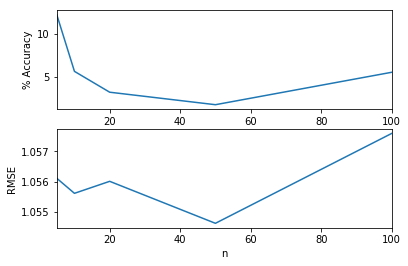

In [510]:
fig1, (ax1,ax2) = plt.subplots(2,1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[0]).mean().loc[:,'Accuracy'].plot(ax=ax1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[0]).mean().loc[:,'RMSE'].plot(ax=ax2)
ax1.set_ylabel('% Accuracy')
ax2.set_ylabel('RMSE')

The RMSE is similar for all values of n, however the accuracy is better for low n, therefore n=5 will be chosen as the final parameter value.

Next, k will be optimized, while giving the highest weight to the item content-based model.

In [513]:
for i in range(1,6):
    for k in [2, 5, 10, 15, 20]:
        recommendmodel(i, 5, 5, k, 20, 0.25, 0.25, 0.25, 1, 0.5, sub=True)

Text(0, 0.5, 'RMSE')

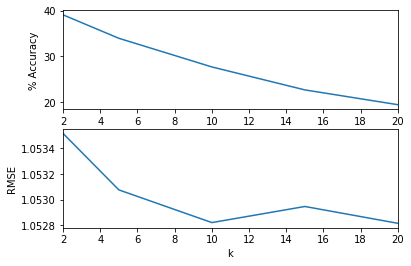

In [514]:
fig2, (ax1,ax2) = plt.subplots(2,1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[1]).mean().loc[:,'Accuracy'].plot(ax=ax1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[1]).mean().loc[:,'RMSE'].plot(ax=ax2)
ax1.set_ylabel('% Accuracy')
ax2.set_ylabel('RMSE')

The RMSE is similar for all values of k, however the accuracy is better for low k, therefore k=2 will be chosen as the final parameter value. k will not be lowered further because it must be greater than 1 to be able to discriminate based on density.

Next, N (the number of neighbors for collaborative filtering) will be optimized, while giving the highest weight to the collaborative model.

In [518]:
for i in range(1,6):
    for N in [5, 10, 20, 50, 100]:
        recommendmodel(i, 5, 5, 2, N, 0.25, 0.25, 0.25, 0, 0.5, sub=True)

Text(0, 0.5, 'RMSE')

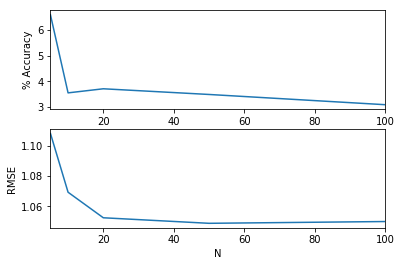

In [520]:
fig3, (ax1,ax2) = plt.subplots(2,1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[2]).mean().loc[:,'Accuracy'].plot(ax=ax1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[2]).mean().loc[:,'RMSE'].plot(ax=ax2)
ax1.set_ylabel('% Accuracy')
ax2.set_ylabel('RMSE')

RMSE is similar for different levels of N, but low N is slighty worse probably due to overfitting. Accuracy improves a little with low N. As a compromise between the RMSE and Accuracy, N = 10 will be selected.

While fixing n, k, and N, the weights of the different user similarity measures will be varied. The weights are constrained between 0 and 1 so a mixture design will be used (the corners, edge midpoints, face midpoints, and center of a tetrahedron). The highest weight will be given to the collarborative model.

In [521]:
for i in range(1,6):
    for Wg, Wl, Wr in [[0.25,0.25,0.25],
                       [1,0,0],[0,1,0],[0,0,1],[0,0,0],
                       [0.5,0.5,0],[0.5,0,0.5],[0.5,0,0],[0,0.5,0.5],[0,0.5,0],[0,0,0.5],
                       [0,1/3,1/3],[1/3,0,1/3],[1/3,1/3,0],[1/3,1/3,1/3]]:
        recommendmodel(i, 5, 5, 2, 10, Wg, Wl, Wr, 0, 0.5, sub=True)

In [526]:
optimizationresults.iloc[-75:,:].groupby(list(optimizationresults)[3:6]).mean().loc[:,['Accuracy','RMSE']]

Accuracy      RMSE
Wg       Wl       Wr                          
0.000000 0.000000 0.000000  2.132380  1.076141
                  0.500000  2.672132  1.064889
                  1.000000  2.406763  1.061091
         0.333333 0.333333  2.804852  1.073211
         0.500000 0.000000  2.380109  1.076223
                  0.500000  3.176416  1.072197
         1.000000 0.000000  2.671992  1.076826
0.250000 0.250000 0.250000  3.548156  1.069325
0.333333 0.000000 0.333333  3.238422  1.067813
         0.333333 0.000000  3.141030  1.075171
                  0.333333  4.512465  1.071073
0.500000 0.000000 0.000000  2.769384  1.073718
                  0.500000  3.123319  1.067305
         0.500000 0.000000  4.830932  1.074004
1.000000 0.000000 0.000000  4.565527  1.076218

Once again the RMSE is lowest for using ratings only to calculate similarity, however RMSE is comparable for all combinations. However, the accuracy is highest for the 50/50 combination of genre and latent factors.

The weight of Wgenre vs Wlatent can be fine tuned.

In [535]:
for i in range(1,6):
    for Wg, Wl in [[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.6,0.4],[0.8,0.2]]:
        recommendmodel(i, 5, 5, 2, 10, Wg, Wl, 0, 0, 0.5, sub=True)

In [537]:
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[3]).mean()

,Wl,Wr,Wi,Wil,Accuracy,RMSE
Wg,,,,,,
0.2,0.8,0.0,0.0,0.5,3.910707,1.077535
0.3,0.7,0.0,0.0,0.5,4.308855,1.076393
0.4,0.6,0.0,0.0,0.5,4.547793,1.075176
0.6,0.4,0.0,0.0,0.5,4.733598,1.072911
0.8,0.2,0.0,0.0,0.5,4.822070,1.069664


Text(0, 0.5, 'RMSE')

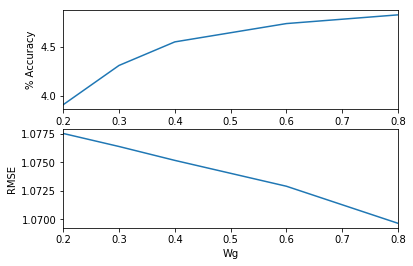

In [538]:
fig4, (ax1,ax2) = plt.subplots(2,1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[3]).mean().loc[:,'Accuracy'].plot(ax=ax1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[3]).mean().loc[:,'RMSE'].plot(ax=ax2)
ax1.set_ylabel('% Accuracy')
ax2.set_ylabel('RMSE')

The 50/50 combination has comparable accuracy to the 80/20 combination, but the RMSE is lower for the 80/20 combination, so that will be selected for the final weights.

Next, we optimize the weight of genre vs latent features in content-based filtering.

In [557]:
for i in range(1,6):
    for Wil in [0, 0.25, 0.5, 0.75, 1]:
        recommendmodel(i, 5, 5, 2, 10, 0.25, 0.25, 0.25, 1, Wil, sub=True)

Text(0, 0.5, 'RMSE')

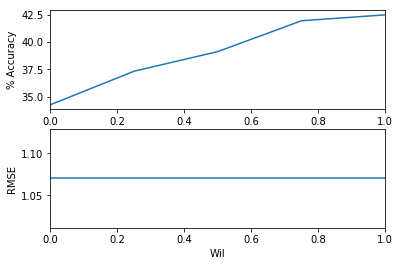

In [534]:
fig5, (ax1,ax2) = plt.subplots(2,1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[7]).mean().loc[:,'Accuracy'].plot(ax=ax1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[7]).mean().loc[:,'RMSE'].plot(ax=ax2)
ax1.set_ylabel('% Accuracy')
ax2.set_ylabel('RMSE')

The accuracy increases with larger contribution of latent features compared to genre. This increase plateaus after Wil = 0.75, so 0.75 will be used as the final Wil.

Finally the balance between the collaborative and content-based model is optimized.

In [542]:
for i in range(1,6):
    for Wi in [0, 0.25, 0.5, 0.75, 1]:
        recommendmodel(i, 5, 5, 2, 10, 0.8, 0.2, 0, Wi, 0.75, sub=True)

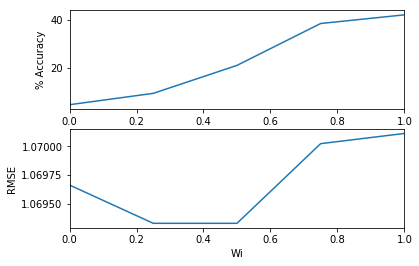

In [555]:
fig6, (ax1,ax2) = plt.subplots(2,1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[6]).mean().loc[:,'Accuracy'].plot(ax=ax1)
optimizationresults.iloc[-25:,:].groupby(list(optimizationresults)[6]).mean().loc[:,'RMSE'].plot(ax=ax2)
ax1.set_ylabel('% Accuracy')
ax2.set_ylabel('RMSE')
ax2.ticklabel_format(useOffset=False)

RMSE is almost the same for all values of Wi. The accuracy increases with larger contribution of item. This increase plateaus after Wil= 0.75, so 0.75 will be used as the final Wi.

These parameters are transferred to the full data set for evaluation. Since the full set is larger, the values of k and N will be scaled up from 2 and 10 to 4 and 20 respectively.

In [570]:
recommendmodel(1, 5, 5, 4, 20, 0.8, 0.2, 0, 0.75, 0.75)

,UserID,MovieID,Rating,Timestamp,watchpredict,ratepredict
0,6040,858,4,956703932,1,5
1,6040,2384,4,956703954,1,4
2,6040,593,5,956703954,1,4
3,6040,1961,4,956703977,1,4
4,6040,2019,5,956703977,1,4
5,6040,1419,3,956704056,1,4
6,6040,213,5,956704056,1,4
7,6040,3111,5,956704056,1,4
8,6040,573,4,956704056,1,3
9,6040,3505,4,956704056,1,4


In [571]:
optimizationresults.iloc[-1,:]

n                 5
k                 4
N                20
Wg              0.8
Wl              0.2
Wr                0
Wi             0.75
Wil            0.75
Accuracy     27.028
RMSE        1.03479
Name: 293, dtype: object

After optimization, the RMSE is about the same but the accuracy is improved.

A moving average plot of the predicted accuracy is shown below.

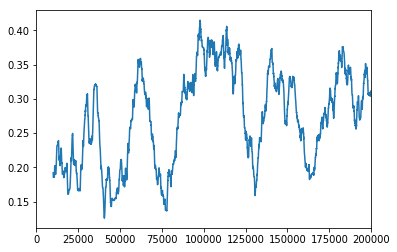

In [580]:
testratings.watchpredict.rolling(10000).mean().plot()

The plot shows no clear trend with time (predictions do not become more or less accurate over time).

The R squared value for the rating prediction is calculated below.

In [593]:
1-(optimizationresults.iloc[-1,-1]/ratings.Rating.std())**2

0.1419454252500697

The R squared value shows the predicted rating is only slightly more accurate than the average rating.

However, as seen from the histogram below, Most ratings are between 3-5 with a maximum at 4. This suggests low variance in the ratings, which means most factors may have little effect on ratings, in which case a lower R squared value may be expected since simply using the mean rating would predict the ratings quite well. 

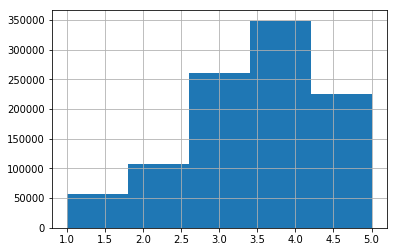

In [594]:
ratings.Rating.hist(bins=5)

Overall these results seem poor, but they can further be examined by splitting the results by old users, as well as old vs. new movies.

In [591]:
print('Accuracy for old users:', 100*testratings.loc[testratings.UserID.isin(userslist),'watchpredict'].mean())
print('Accuracy for new users:', 100*testratings.loc[~(testratings.UserID.isin(userslist)),'watchpredict'].mean())
print('Accuracy for old movies:', 100*testratings.loc[testratings.MovieID.isin(movieslist),'watchpredict'].mean())
print('Accuracy for new movies:', 100*testratings.loc[~(testratings.MovieID.isin(movieslist)),'watchpredict'].mean())

Accuracy for old users: 80.87982731183135
Accuracy for new users: 2.0025773573300922
Accuracy for old movies: 27.02532436689083
Accuracy for new movies: 41.66666666666667


In [592]:
testresults = testratings
testresults['sqdifference']= (testresults['ratepredict']-testresults['Rating'])**2
print('RMSE for old users:', testresults.loc[testresults.UserID.isin(userslist),'sqdifference'].mean()**0.5)
print('RMSE for new users:', testresults.loc[~(testresults.UserID.isin(userslist)),'sqdifference'].mean()**0.5)
print('RMSE for old movies:', testresults.loc[testresults.MovieID.isin(movieslist),'sqdifference'].mean()**0.5)
print('RMSE for new movies:', testresults.loc[~(testresults.MovieID.isin(movieslist)),'sqdifference'].mean()**0.5)

RMSE for old users: 1.0166573958541048
RMSE for new users: 1.0431021759431993
RMSE for old movies: 1.0347479076660118
RMSE for new movies: 1.224744871391589


New movies have higher recall than old movies. This is probably due to bias on the part of the algorithm. A user is predicted to have watched a new movie when a majority of nearest neighbor users have watched any movie of the same genre combination. This tends to predict that the user will watch a movie more often than for old movies, which are predicted, at least in part, from whether nearest neighbors have watched that specific movie. 

The largest difference is seen between new and old users. Recall is 81% for old users and only 2% for new users. This means that demographic information is not a good predictor of what movies a user will want to watch. However, without previous user history or similarity to other users based on rating/viewing history, there is no other information to base the prediction on.

The old users and old movies have slightly lower RMSE than for new users and movies. The biggest difference in RMSE is between old and new movies. New movie ratings are predicted only from how neighbors rated movies of the same genre combination, which does not take into account whether the movie was good or not (surprisingly the RMSE is even higher than the standard deviation of all ratings from the mean). On the other hand old movies are rated on how neighbors rated that specific movie. This confirms the assumption that was made before that neighboring users' ratings of a specific movie is more accurate than the users' ratings of neighboring movies (in terms of genre).

Overall, however, in predicting whether user will even watch a particular movie, the match between the content of the movie (at least in terms of latent factors - not as much in terms of genre) and user's history is more important than whether similar neighbors watched a movie.

It is clear the model suffers from the cold-start problem in terms of users and movies. However, in reality after some users begin to watch a new movie, or after a new user begins to watch movies, this problem would be reduced. The cold-start problem is exaggerated in the above prediction because the last 1/5 of the data set is predicted all at once from the training set (first 4/5 of the data) whereas in practice the model would be updated as new users start watching movies.

The model above can be used to create a recommender system as follows: The product of the unrounded watching and rating predictions may be used to rank the movies and the top number of movies may be recommended.